In [1]:
import os
os.chdir('..')

import numpy as np
import tensorflow as tf
from yolov4.get_bounding_boxes import YoloModel
from sparse_coding_torch.utils import VideoGrayScaler, MinMaxScaler
import torchvision
from sparse_coding_torch.utils import plot_video
import tensorflow.keras as keras

2022-09-20 19:04:53.559420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 19:04:53.561532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 19:04:53.563471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 19:04:53.565520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 19:04:53.575543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [2]:
from sparse_coding_torch.onsd.video_loader import FrameLoader

video_path = "/shared_data/bamc_onsd_data/revised_extended_onsd_data/"
transforms = torchvision.transforms.Compose(
    [
#      MinMaxScaler(0, 255),
#      torchvision.transforms.Resize((1000, 1000))
    ])

dataset = FrameLoader(video_path, 224, 224, transform=None, yolo_model=None)

Loaded 1078 positive examples.
Loaded 2860 negative examples.


In [150]:
import random

sample_idx = random.choice(range(len(dataset.get_frames())))

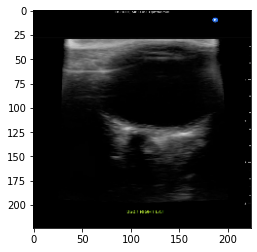

In [151]:
from matplotlib.pyplot import imshow

frame = dataset.get_frames()[sample_idx].swapaxes(0, 2).swapaxes(0, 1)
label = dataset.get_labels()[sample_idx]

imshow(frame)

In [152]:
print(label)

0.0


In [ ]:
# yolo_model = YoloModel('onsd')
video_path = "/shared_data/bamc_onsd_data/revised_extended_onsd_data/"
classifier_model = keras.models.load_model('sparse_coding_torch/onsd/valid_frame_model/best_classifier.pt/')

transforms = torchvision.transforms.Compose(
    [
#      MinMaxScaler(0, 255),
     torchvision.transforms.Resize((224, 224))
    ])

In [ ]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from matplotlib import cm
import math
from tqdm import tqdm
import glob
from os.path import join, abspath

labels = [name for name in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, name))]

videos = []
for label in labels:
    videos.extend([(label, abspath(join(video_path, label, f)), f) for f in glob.glob(join(video_path, label, '*', '*.mp4'))])

all_widths = []
all_colors = []
for label, path, vid_f in tqdm(videos):
    vc = torchvision.io.read_video(path)[0].permute(3, 0, 1, 2)
    
    orig_height = vc.size(2)
    orig_width = vc.size(3)

    all_nerve_widths = []
    
    for i in range(0, vc.size(1), 10):
        frame = vc[:, i, :, :].swapaxes(0, 2).swapaxes(0, 1).numpy()

        bounding_boxes, classes, scores = yolo_model.get_bounding_boxes_v5(frame)

        nerve_bbs = [bb for bb, class_pred, score in zip(bounding_boxes, classes, scores) if class_pred==0]
        
        for nerve in nerve_bbs:
            width = (nerve[2] - nerve[0]) * orig_width
            all_nerve_widths.append(width)
            
    if not all_nerve_widths:
        continue
    smallest_width = np.max(np.array(all_nerve_widths))
    
    all_widths.append(smallest_width)
    if label == 'Positives':
        all_colors.append('green')
    elif label == 'Negatives':
        all_colors.append('red')
    else:
        raise Exception('Bad Label')

plt.scatter(all_widths, range(len(all_widths)), color=all_colors)
plt.savefig('onsd_nerve_plot.png')

In [ ]:
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from matplotlib import cm
import math
from tqdm import tqdm
import glob
from os.path import join, abspath

labels = [name for name in os.listdir(video_path) if os.path.isdir(os.path.join(video_path, name))]

videos = []
for label in labels:
    videos.extend([(label, abspath(join(video_path, label, f)), f) for f in glob.glob(join(video_path, label, '*', '*.mp4'))])

best_frames = {}
for label, path, vid_f in tqdm(videos):
    vc = torchvision.io.read_video(path)[0].permute(3, 0, 1, 2)
    
    all_conf = [0] * vc.size(1)
    
    for i in range(0, vc.size(1)):
        frame = vc[:, i, :, :]
        
        frame = transforms(frame).swapaxes(0, 2).swapaxes(0, 1).numpy()
        
        frame = np.expand_dims(frame, axis=0)

        prepro_frame = tf.keras.applications.densenet.preprocess_input(frame)

        pred = classifier_model(prepro_frame)
        
        pred = tf.math.sigmoid(pred)
        
        all_conf[i] = pred
        
    max_idx = np.argmax(np.array(all_conf))
    
    best_frames[vid_f] = max_idx
    print(vid_f)
    print(max_idx)
    print('----------------------')
    
print(best_frames)